<a href="https://colab.research.google.com/github/rafaelrubo/python-geociencias/blob/main/python_geociencias07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.ndimage import sobel, gaussian_filter, laplace
from IPython.display import display, HTML, clear_output
import base64
from google.colab import output
from sklearn.ensemble import RandomForestClassifier
import ipywidgets as widgets

In [2]:
# --- Carregar imagem ---
img = plt.imread("lamina.jpg")
h, w = img.shape[:2]

In [3]:
# --- Calcular atributos: filtros convolucionais ---
R, G, B = img[:, :, 0], img[:, :, 1], img[:, :, 2]
sobel_R, sobel_G, sobel_B = sobel(R), sobel(G), sobel(B)
gauss_R, gauss_G, gauss_B = gaussian_filter(R, 1), gaussian_filter(G, 1), gaussian_filter(B, 1)
dog_R = gaussian_filter(R, 1) - gaussian_filter(R, 2)
dog_G = gaussian_filter(G, 1) - gaussian_filter(G, 2)
dog_B = gaussian_filter(B, 1) - gaussian_filter(B, 2)
hess_R, hess_G, hess_B = laplace(R), laplace(G), laplace(B)

# --- Montar matriz de atributos ---
X = np.stack([
    R.ravel(), G.ravel(), B.ravel(),
    sobel_R.ravel(), sobel_G.ravel(), sobel_B.ravel(),
    gauss_R.ravel(), gauss_G.ravel(), gauss_B.ravel(),
    dog_R.ravel(), dog_G.ravel(), dog_B.ravel(),
    hess_R.ravel(), hess_G.ravel(), hess_B.ravel()
], axis=1)

In [4]:
# A Anotação usa widgets do IPython e HTML/JavaScript
# Exibe a imagem como elemento HTML, captura cliques via JS, retorna as coordenadas para Python.

# Etapa 1/5: dicionário para armazenar os pontos
classes = {"poro": [], "nao-poro": []}

In [5]:
# Etapa 2/5: função Python para receber dados do JS
def receive_coords(class_name, points):
    classes[class_name] = points

In [6]:
# Etapa 3/5: registrar callback para JS enviar os dados
output.register_callback('notebook.receive_coords', receive_coords)

def annotate_image_dual(image_path):
    # Lê a imagem e converte para base64
    with open(image_path, "rb") as f:
        img_data = f.read()
    img_base64 = base64.b64encode(img_data).decode()

    html = f"""
    <div>
        <h3>Escolha a classe e clique na imagem</h3>
        <select id="classSelect">
            <option value="poro">Poro</option>
            <option value="nao-poro">Não-Poro</option>
        </select>
        <br><br>
        <img id="img" src="data:image/png;base64,{img_base64}" style="max-width:500px;"/>
        <p id="coords">Coordenadas: []</p>
        <button onclick="sendCoords()">Enviar dados para Python</button>
    </div>
    <script>
    var img = document.getElementById("img");
    var coordsDisplay = document.getElementById("coords");
    var points = [];
    var className = "poro";

    document.getElementById("classSelect").onchange = function(e){{
        className = e.target.value;
        points = [];
        coordsDisplay.innerHTML = "Coordenadas: []";
    }};

    img.onclick = function(e){{
        var rect = img.getBoundingClientRect();
        var x = e.clientX - rect.left;
        var y = e.clientY - rect.top;
        points.push([Math.round(x), Math.round(y)]);
        coordsDisplay.innerHTML = "Coordenadas: " + JSON.stringify(points);
    }};

    function sendCoords(){{
        google.colab.kernel.invokeFunction('notebook.receive_coords', [className, points], {{}} );
        alert("Dados enviados para Python!");
        points = [];
        coordsDisplay.innerHTML = "Coordenadas: []";
    }}
    </script>
    """
    display(HTML(html))


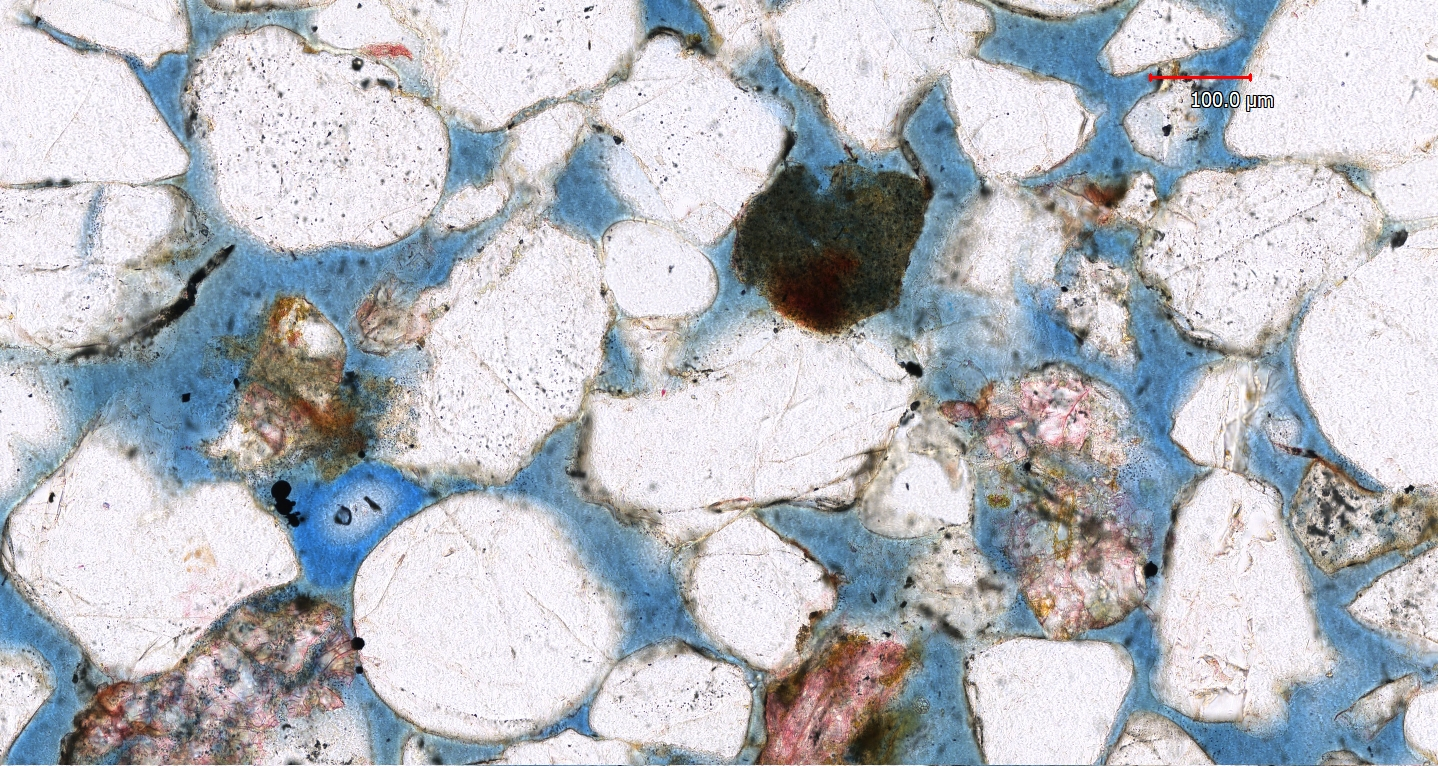

In [7]:
# Etapa 4/5: usar a função
annotate_image_dual("lamina.jpg")

In [8]:
# Etapa 5/5: conferir anotação
print(classes["poro"])       # Lista de pontos anotados como poro
print(classes["nao-poro"])   # Lista de pontos anotados como não-poro

[[111, 194], [11, 260], [4, 217], [55, 29], [371, 18], [438, 262], [426, 258], [336, 264], [329, 229], [286, 190], [225, 211], [116, 199], [142, 176], [117, 105], [209, 73], [239, 6], [360, 20], [439, 4], [423, 257], [36, 134], [55, 32], [240, 7]]
[[88, 61], [37, 37], [50, 10], [172, 16], [243, 52], [306, 19], [350, 43], [404, 13], [467, 30], [279, 98], [298, 80], [101, 148], [113, 147], [45, 196], [70, 235], [290, 236], [281, 239], [370, 207], [432, 209], [483, 127], [385, 113], [470, 24]]


In [9]:
# --- Preparar dados de treino usando o dicionário 'classes' ---
mask_points = []
labels = []

for c in classes:  # classes = {'poro': [...], 'nao-poro': [...]}
    pts = classes[c]
    for (i, j) in pts:
        idx = i * w + j
        mask_points.append(idx)
        labels.append(c)

X_train = X[mask_points]
y_train = np.array(labels)

print(f"Total de pixels rotulados: {len(y_train)}")

Total de pixels rotulados: 44


In [10]:
# --- Treinar Random Forest ---
clf = RandomForestClassifier(n_estimators=300, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

In [11]:
# --- Predição em todos os pixels ---
y_pred = clf.predict(X)
segmented = y_pred.reshape(img.shape[:2])

In [12]:
# Converter as classes string em valores numéricos
unique_labels = np.unique(segmented)
label_map = {label: i for i, label in enumerate(unique_labels)}
segmented_num = np.vectorize(label_map.get)(segmented)

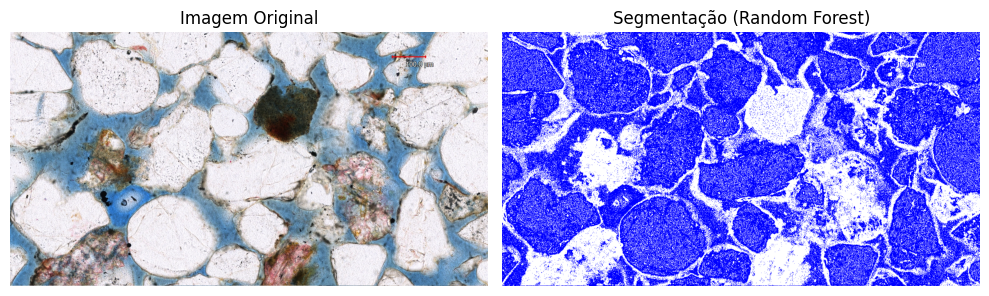

In [13]:
# === Visualização simples lado a lado ===

# Criar colormap com base nas classes únicas
colors = ['blue', 'white'][:len(unique_labels)]  # expande se tiver mais classes
cmap_custom = ListedColormap(colors)

# Plotar lado a lado
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img)
axes[0].set_title("Imagem Original")
axes[0].axis('off')

axes[1].imshow(segmented_num, cmap=cmap_custom, vmin=0, vmax=len(unique_labels)-1)
axes[1].set_title("Segmentação (Random Forest)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [14]:
# === Visualização com sobreposição e transparência ===

# --- Colormap personalizado ---
cmap_custom = ListedColormap(['blue', 'white'])

# --- Função para exibir imagem com widgets ---
def show_segmented(alpha=0.5, show_seg=True):
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    if show_seg:
        plt.imshow(segmented_num, cmap=cmap_custom, alpha=alpha, vmin=0, vmax=1)
    plt.axis('off')
    plt.show()

# --- Widgets para controlar alpha e mostrar/ocultar segmentação ---
alpha_slider = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.01, description='Transparência:')
toggle_seg = widgets.Checkbox(value=True, description='Mostrar segmentação')

ui = widgets.VBox([alpha_slider, toggle_seg])

out = widgets.interactive_output(show_segmented, {'alpha': alpha_slider, 'show_seg': toggle_seg})
display(ui, out)

Output()

In [15]:
# === Análise quantitativa ===

# Contar pixels por classe
unique, counts = np.unique(segmented_num, return_counts=True)

# Converter para dicionário {classe: número de pixels}
counts_dict = dict(zip(unique, counts))

# Calcular percentual
total_pixels = segmented_num.size
percent_por_classe = {cls: 100 * n / total_pixels for cls, n in counts_dict.items()}

print("Percentual por classe:")
for cls, perc in percent_por_classe.items():
    nome = "Poro" if cls == 0 else "Não-Poro"
    print(f"{nome}: {perc:.2f}%")

Percentual por classe:
Poro: 59.11%
Não-Poro: 40.89%
